In [2]:
import numpy as np
import pandas as pd

from fastai.vision.all import *

import albumentations as Alb

* albumentations
    * image augmentation in pytorch

In [3]:
# local
INPUT_PATH = './paddy-disease-classification'
# kaggle
# INPUT_PATH = '../input/paddy-disease-classification'
TRAIN_PATH = INPUT_PATH + '/train_images'
TEST_PATH = INPUT_PATH + '/test_images'

### albumentations
* 데이터 증강 라이브러리
* ShiftScaleRotate
* Transpose
* Flip: horizontally, vertically or both
* RandomRotate90
* RandomBrightnessContrast
    * brightness_limit: default (-0.2, 0.2)
    * contrast_limit: default (-0.2, 0.2)
* HueSaturationValue - 색상, 채도, 명도
* https://albumentations.ai/docs/api_reference/full_reference/


* Resize - 이미지 크기 변경
* Normalize - 이미지 Normalize

In [4]:
# 이미지 증식
class AlbTransform(Transform):
    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

def get_augs():
    return Alb.Compose([
        Alb.ShiftScaleRotate(rotate_limit=20, border_mode=0),
        Alb.Transpose(),
        Alb.Flip(),
        Alb.RandomRotate90(),
        Alb.RandomBrightnessContrast(),
        Alb.HueSaturationValue(
            hue_shift_limit=5,
            sat_shift_limit=5,
            val_shift_limit=5
        )
    ])

item_tfms = [Resize(224), AlbTransform(get_augs())]
batch_tfms = Normalize.from_stats(*imagenet_stats)

* ImageDataLoaders
    * item_tfms: batching 전에 변형
    * batch_tfms: batches 에 적용
    * bs: 배치 크기
    * val_bs: batch size of validation (default - bs)
    * shuffle_train: shuffle or not
* from_folder
    * train, valid: subfolders in path
    * valid_pct: random split with percentage

In [5]:
# create datalodaer from the folder structure
dls = ImageDataLoaders.from_folder(
    TRAIN_PATH,
    train='.',
    valid=None,
    valid_pct=0.01,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    bs=32,
    shuffle=True
)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [6]:
print('train items:', len(dls.train.items), 'validation items:', len(dls.valid.items))
dls.vocab

train items: 10303 validation items: 104


['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

* vision_learner
    * https://docs.fast.ai/vision.learner.html#vision_learner
    * resnet50
    * loss func - FocalLoss
        * crossentropy의 클래스 불균형 문제 다루기 위한 개선된 버전
        * 어렵거나 쉽게 오분류되는 케이스에 대하여 더 큰 가중치를 주는 방법
        * Cross Entropy Loss 잘못 예측한 경우에 대하여 페널티 부여하는 것에 초점
        * https://gaussian37.github.io/dl-concept-focal_loss/

In [7]:
learn = vision_learner(
    dls,
    resnet50,
    path='.',
    loss_func=FocalLoss(),
    metrics=[accuracy]
)

c:\Users\posky\anaconda3\envs\torch1x\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\posky\anaconda3\envs\torch1x\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
learn.summary()

Sequential (Input shape: 32 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     32 x 256 x 56 x 56  
Conv2d                                    16384      False     
BatchNorm2d                        

* fine_tune(epochs, base_lr=0.002, freeze_epochs=1, lr_mult=100, pct_start=0.3, div=5, ...)
    * freeze -> one_cycle -> unfreeze -> one_cycle 한번에 진행
    * freeze: 각 레이어의 trainable을 False (freeze_to(-1)가 default)
    * classifier 빼놓고 앞단의 레이어들의 trainable=False
    
    * freeze_epochs 동안 classifier 빼놓고 앞단의 레이어들의 trainable=False => classifier learning
    * epochs 동안 모든 레이어 trainable=True and learning

In [11]:
learn.fine_tune(100, freeze_epochs=1, cbs=[ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

* get_image_files(path, recurse=True, folders=None)
    * Get image files in *path* recursively, only in *folders*, if specified.

In [15]:
ftest = get_image_files(TEST_PATH)
print('Testing', len(ftest), 'items')

Testing 3469 items


* DataLoader.test_dl
    * Create a test dataloader from *test_items* using validation transforms of *dls*
    * with_labels: Whether the test items contain labels
    * shuffle: Whether to shuffle data passed to

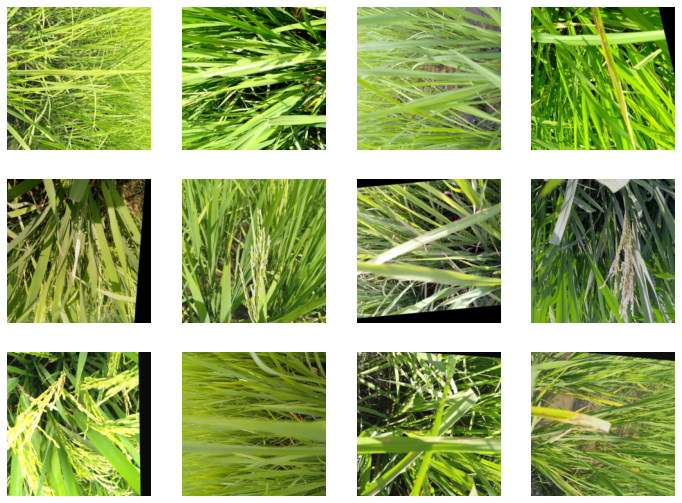

In [16]:
# make dataloader for test data
tst_dl = dls.test_dl(ftest, with_labels=False, shuffle=False)
tst_dl.show_batch(max_n=12)

* Learner.tta(ds_idx=1, dl=None, n=4, item_tfms=None, batch_tfms=None, beta=0.25, use_max=False)
    * Return predictions on the ds_idx dataset or dl using Test Time Augmentation
    * prediction *n* times with the transforms of the training set and average those.
    * The final predictions are *(1-beta)* multiplied by this average + *beta* multiplied by the predictions obtained with the transforms of the dataset

* Test Time Augmentation (TTA)
    * 예측하는동안 데이터 증식을 사용해서 모델의 정확도를 개선하는 과정
    * https://medium.com/geekculture/fastai-chapter-7-questions-answers-6f6dcc83dd9f

In [ ]:
%%time

preds = learn.tta(dl=tst_dl, n=32, use_max=False)

In [ ]:
predss = learn.dls.vocab[np.argmax(preds[0], axis=1)]
subm_df = pd.DataFrame()
subm_df['image_id'] = [item.name for item in tst_dl.items]
subm_df['label'] = predss
subm_df.to_csv('fasiai2_submission.csv', header=True, index=False)